# Traditional algorithm for material parameter extraction from THz-TDS of a sample

## Import data and find initial rough value of n

In [1]:
from utils import move_to_thz_tds_directory
move_to_thz_tds_directory()

Success! Current directory is now: /Users/theosmith/Documents/MPhys_YiER_Project/Git_repo/THz-TDS


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft

# Constants

Length = 3000 * 1e-6  # Convert to meters
c = 299792458  # Speed of light in m/s

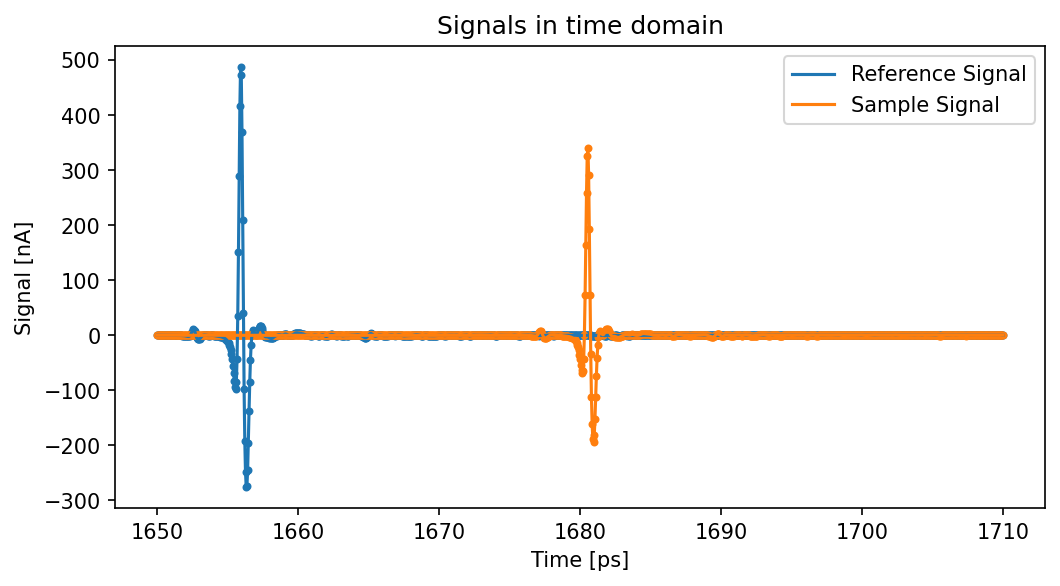

In [3]:
# Load the data
ref_tab = pd.read_csv("Data_sets/simple_data/ref.pulse.csv").to_numpy()
sample_tab = pd.read_csv("Data_sets/simple_data/Si.pulse.csv").to_numpy()

# Extract the signals and time data
signal_ref = ref_tab[:, 1]
signal_sample = sample_tab[:, 1]

time_ref = ref_tab[:, 0]
time_sample = sample_tab[:, 0]

# Calculate offset and padding
offset = time_sample[0] - time_ref[0]
time_step = time_ref[1] - time_ref[0]
n_padding = int(offset / time_step)

# Adjust time and signal arrays by padding
time_ref = np.concatenate([time_ref, np.linspace(time_ref[-1], time_sample[-1], n_padding)])
time_sample = np.concatenate([np.linspace(time_ref[0], time_sample[0], n_padding), time_sample])
signal_ref = np.concatenate([signal_ref, np.zeros(n_padding)])
signal_sample = np.concatenate([np.zeros(n_padding), signal_sample])

# Time and frequency domain parameters
T = time_step
Fs = 1 / T
L = len(signal_ref)
t = np.arange(0, L) * T
f = Fs / L * np.arange(0, L)    # Frequency values

# Plot the signals
plt.figure(figsize=(8,4),dpi=150)
plt.plot(time_ref, signal_ref, label="Reference Signal")
plt.scatter(time_ref, signal_ref, s=8)
plt.plot(time_sample, signal_sample, label="Sample Signal")
plt.scatter(time_sample, signal_sample, s=8)
plt.title('Signals in time domain')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

### Use signal delay to approximate the real refractive index

In [4]:
# Calculate delay for analytical solution

max_signal_ref_time = time_ref[np.argmax(signal_ref)]
max_signal_sample_time = time_sample[np.argmax(signal_sample)]

delay = (max_signal_sample_time - max_signal_ref_time) * (1e-12)    # Convert to seconds from picoseconds

# Formula from Aaron Chung Thesis (Page 18)
n_avg = 1 + ((c * delay) / Length)
print(f'Average Refractive index of sample: {n_avg}')

Average Refractive index of sample: 3.463294696566653


## Fourier Transform data to work in Frequency domain and extract material parameters

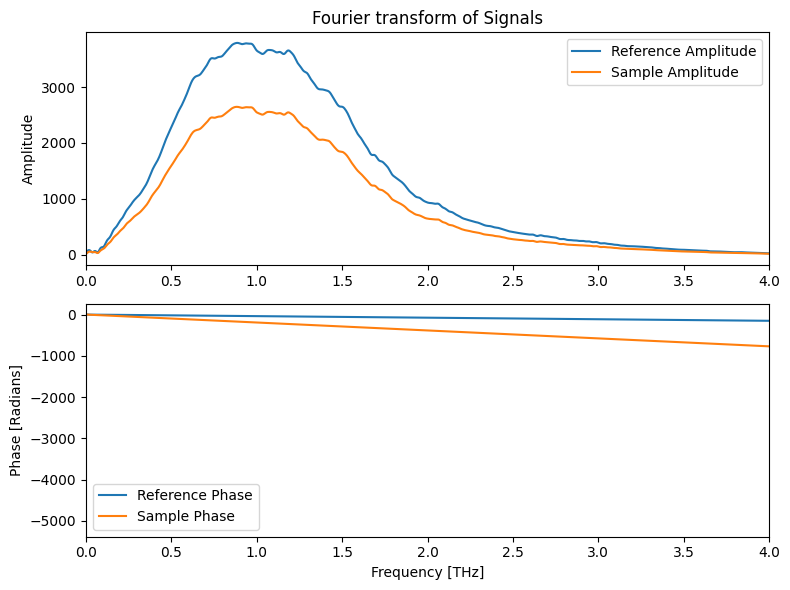

In [5]:
# Define interpolation factor
interpolation = 2**12

# Compute FFTs of both signals with interpolation
fft_ref = fft(signal_ref, interpolation)
fft_sample = fft(signal_sample, interpolation)

# Calculate amplitude and phase for both signals
A_signal_ref = np.abs(fft_ref)
ph_signal_ref = np.unwrap(np.angle(fft_ref))

A_signal_sample = np.abs(fft_sample)
ph_signal_sample = np.unwrap(np.angle(fft_sample))

# Adjust frequency array for interpolation
f_interp = np.linspace(f[0], f[-1], interpolation)

# Create a tiled layout for plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot amplitude spectrum
axs[0].plot(f_interp, A_signal_ref, label='Reference Amplitude')
axs[0].plot(f_interp, A_signal_sample, label='Sample Amplitude')
axs[0].set_xlim([0, 4])
axs[0].set_title('Fourier transform of Signals')
#axs[0].set_xlabel('Frequency [THz]')
axs[0].set_ylabel('Amplitude')
axs[0].legend()

# Plot phase spectrum
axs[1].plot(f_interp, ph_signal_ref, label='Reference Phase')
axs[1].plot(f_interp, ph_signal_sample, label='Sample Phase')
axs[1].set_xlim([0, 4])
axs[1].set_xlabel('Frequency [THz]')
axs[1].set_ylabel('Phase [Radians]')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

### Calculate experimental transfer function 

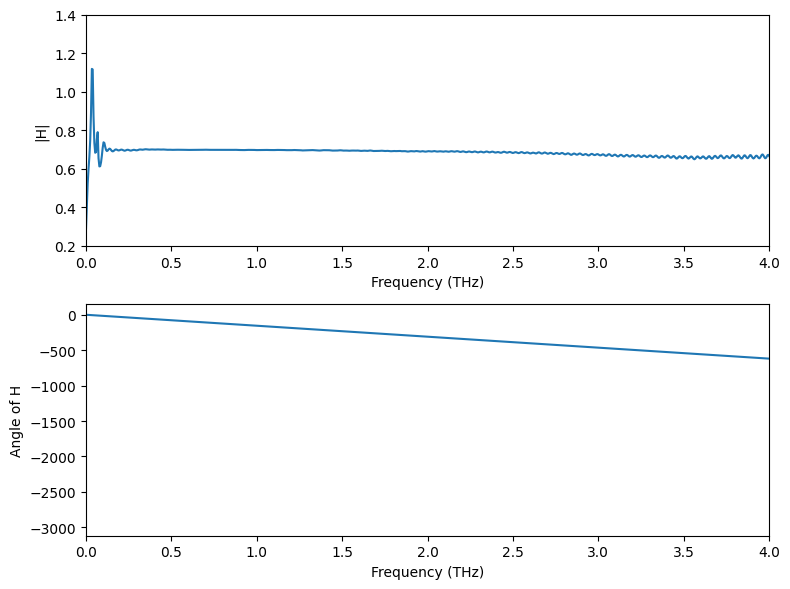

In [6]:
# Compute the complex transfer function H_exp_general
H_exp_general = (A_signal_sample * np.exp(1j * ph_signal_sample)) / (A_signal_ref * np.exp(1j * ph_signal_ref))

# Get amplitude and phase of H_exp_general
A_exp = np.abs(H_exp_general)
ph_exp = np.unwrap(np.angle(H_exp_general))

# Plot the amplitude and phase of H_exp_general
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

def plot_experimental_tf(H_exp_general: np.ndarray):
    # Plot |H|
    axs[0].plot(f_interp, A_exp)
    axs[0].set_xlabel("Frequency (THz)")
    axs[0].set_ylabel("|H|")
    axs[0].set_xlim([0, 4])
    axs[0].set_ylim([0.2, 1.4])

    # Plot angle of H
    axs[1].plot(f_interp, ph_exp)
    axs[1].set_xlabel("Frequency (THz)")
    axs[1].set_ylabel("Angle of H")
    axs[1].set_xlim([0, 4])


    # Display the plots
    plt.tight_layout()
    plt.show()

plot_experimental_tf(H_exp_general)

### Use phase change to approximate n($\omega$)

/var/folders/q2/m5_vfjhs3m5b5szm6q3l9dlr0000gn/T/ipykernel_48162/2429498878.py:3: RuntimeWarning: invalid value encountered in divide
  n_approx = 1 + (np.abs(ph_exp) * c) / (f_interp * 1e12 * 2 * np.pi * Length)


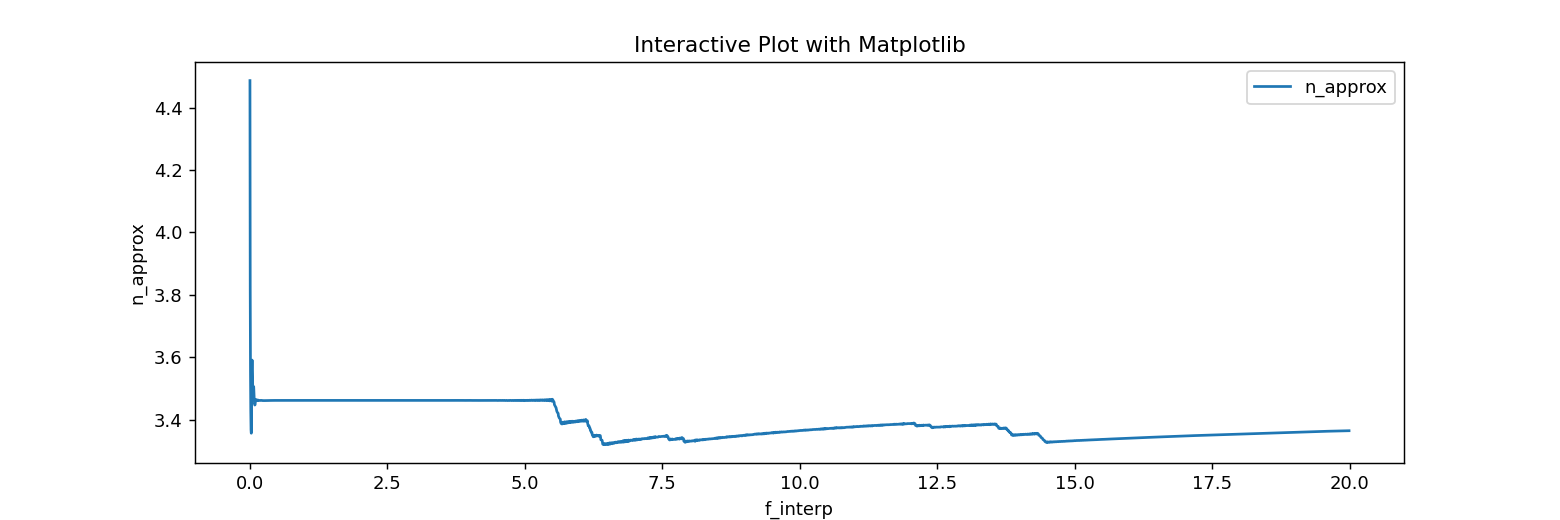

In [7]:
%matplotlib widget

n_approx = 1 + (np.abs(ph_exp) * c) / (f_interp * 1e12 * 2 * np.pi * Length)



# Create the plot
plt.figure(figsize=(12,4), dpi=130)
plt.plot(f_interp, n_approx, label='n_approx')
# Add labels and legend
plt.xlabel('f_interp')
plt.ylabel('n_approx')
plt.title('Interactive Plot with Matplotlib')
plt.legend()

# Show the plot
plt.show()

### Use Newton-Raphson method to find ñ(⍵)

In [8]:
# Initial refractive index
n_0 = 3.7 + 0.1j
n_next = n_0

# Define H_th and H_prime functions
def H_th_function(n, w):
    return (4 * n) / ((n + 1) ** 2) * np.exp(-1j * (n - 1) * w * Length / c)

def H_prime_function(n, w):
    return (1 / n) - (2 / (n + 1)) - 1j * w * Length / c

# Array to store extracted refractive indices
n_extracted = np.zeros(interpolation, dtype=complex)

# Iterate through frequency indices
for f_index in range(interpolation):
    # print(f'f_index value {f_index}')     # debugging step
    n_next = n_0  # Reset n_next for each frequency index
    for j in range(10):  # Arbitrary number of iterations
        w = 2 * np.pi * f_interp * 1e12  # Convert to angular frequency in radians/sec
        H_th = H_th_function(n_next, w)
        A_th = np.abs(H_th)
        ph_th = np.unwrap(np.angle(H_th))

        # Function to optimize
        fun = np.log(A_th[f_index]) - np.log(A_exp[f_index]) + 1j * ph_th[f_index] - 1j * ph_exp[f_index]
        fun_prime = H_prime_function(n_next, 2 * np.pi * f_interp[f_index] * 1e12)

        # Newton-Raphson method to update n_next
        n_next = n_next - fun / fun_prime

    # Store extracted refractive index
    n_extracted[f_index] = n_next

In [9]:
complex_n = 3.7 + 0.1j

print(type(complex_n))

<class 'complex'>


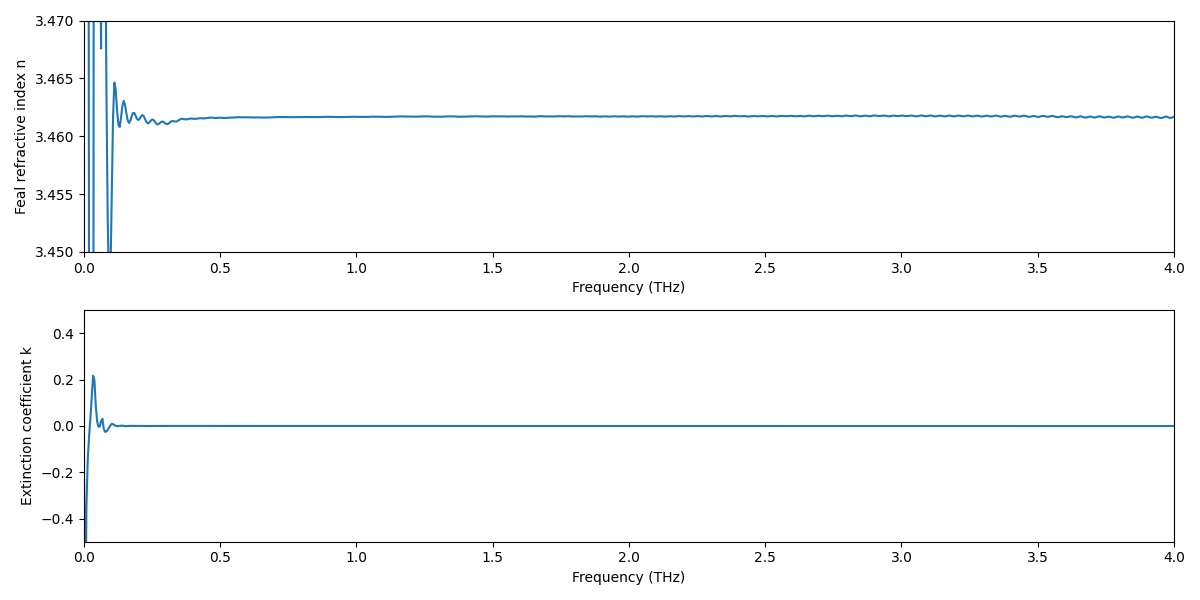

In [10]:
# Create a tiled layout for plotting real and imaginary parts of n_extracted
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# Plot real part of refractive index
axs[0].plot(f_interp, np.real(n_extracted))
axs[0].set_xlim([0, 4])
axs[0].set_ylim([3.45, 3.47])
axs[0].set_xlabel("Frequency (THz)")
axs[0].set_ylabel("Feal refractive index n")

# Plot imaginary part of refractive index (extinction coefficient)
axs[1].plot(f_interp, np.imag(n_extracted))
axs[1].set_xlim([0, 4])
axs[1].set_ylim([-0.5, 0.5])
axs[1].set_xlabel("Frequency (THz)")
axs[1].set_ylabel("Extinction coefficient k")

# Display the plots
plt.tight_layout()
plt.show()